### This assumes that one has a broad spectrum as an input

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from Biquad.Biquad_Daq import Biquad_Daq
from Waveforms.Waveform import Waveform

from Utils.PlotTools import PlottingTools as pt

import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, HBox
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
daq = Biquad_Daq(None, None, 4, 2**10)

Turning on SYNC
Turning off SYNC


In [2]:
def capture_extended(loop=6):
    filttered_arr = np.array([])
    unfilterred_arr = np.array([])
    for i in range(loop):
        daq.JupyterAcquire()
        unfilterred_arr = np.concatenate((unfilterred_arr, daq.waveforms[0].waveform))
        filttered_arr = np.concatenate((filttered_arr, daq.waveforms[2].waveform))
        
    return Waveform(filttered_arr), Waveform(unfilterred_arr)

In [3]:
def capture_loop(iterations, loop=6):
    S21_arr = []
    group_delay_arr = []

    N = 512*loop
    T = 3.E9
    dt = 1/T
    
    xf = np.linspace(0.0, 1.0 / (2 * dt), N // 2)
    
    for i in range (iterations):
        filterred, raw = capture_extended(loop)
        
        S21 = filterred.setFreqFFT()/raw.setFreqFFT()
        
        ##Group Delay
        # phase_response = np.angle(filterred.fft_result)
        # unwrapped_phase = np.unwrap(phase_response)
        # delta_f = T / N
        # group_delay = -np.gradient(unwrapped_phase, delta_f)
              
        S21_arr.append(S21)
        # group_delay_arr.append(group_delay[:N//2])
        
    S21_mean = [sum(x) / len(S21_arr) for x in zip(*S21_arr)]
    # group_delay_mean = [sum(x) / len(group_delay_arr) for x in zip(*group_delay_arr)]
    S21_log_mag = 20 * np.log10(np.abs(S21_mean[:N//2]))
    
    return xf, S21_log_mag#, group_delay_mean

In [18]:
def update_coef(A, B, P, Theta):
    
    daq.setA(A)
    daq.setB(B)
    daq.setP(P)
    daq.setTheta(Theta)#*np.pi)
    
    daq.set_single_zero_fir()
    daq.set_f_fir()
    daq.set_g_fir()
    daq.set_F_fir()
    daq.set_G_fir()
    daq.set_pole_coef()
    # daq.set_incremental()

In [24]:
##The widget won't load on my home pc so Here's to hard coding
A = 0.8028107634961998
B = -0.9163499900207577
P = 0.7782168894289043
theta = 0.2996203532999784 * np.pi
update_coef(A, B, P, theta)

-10.664717049615499
-12.49013918962186
Filter Frequency : 463.686509MHz | Magnitude -32.91089182007539


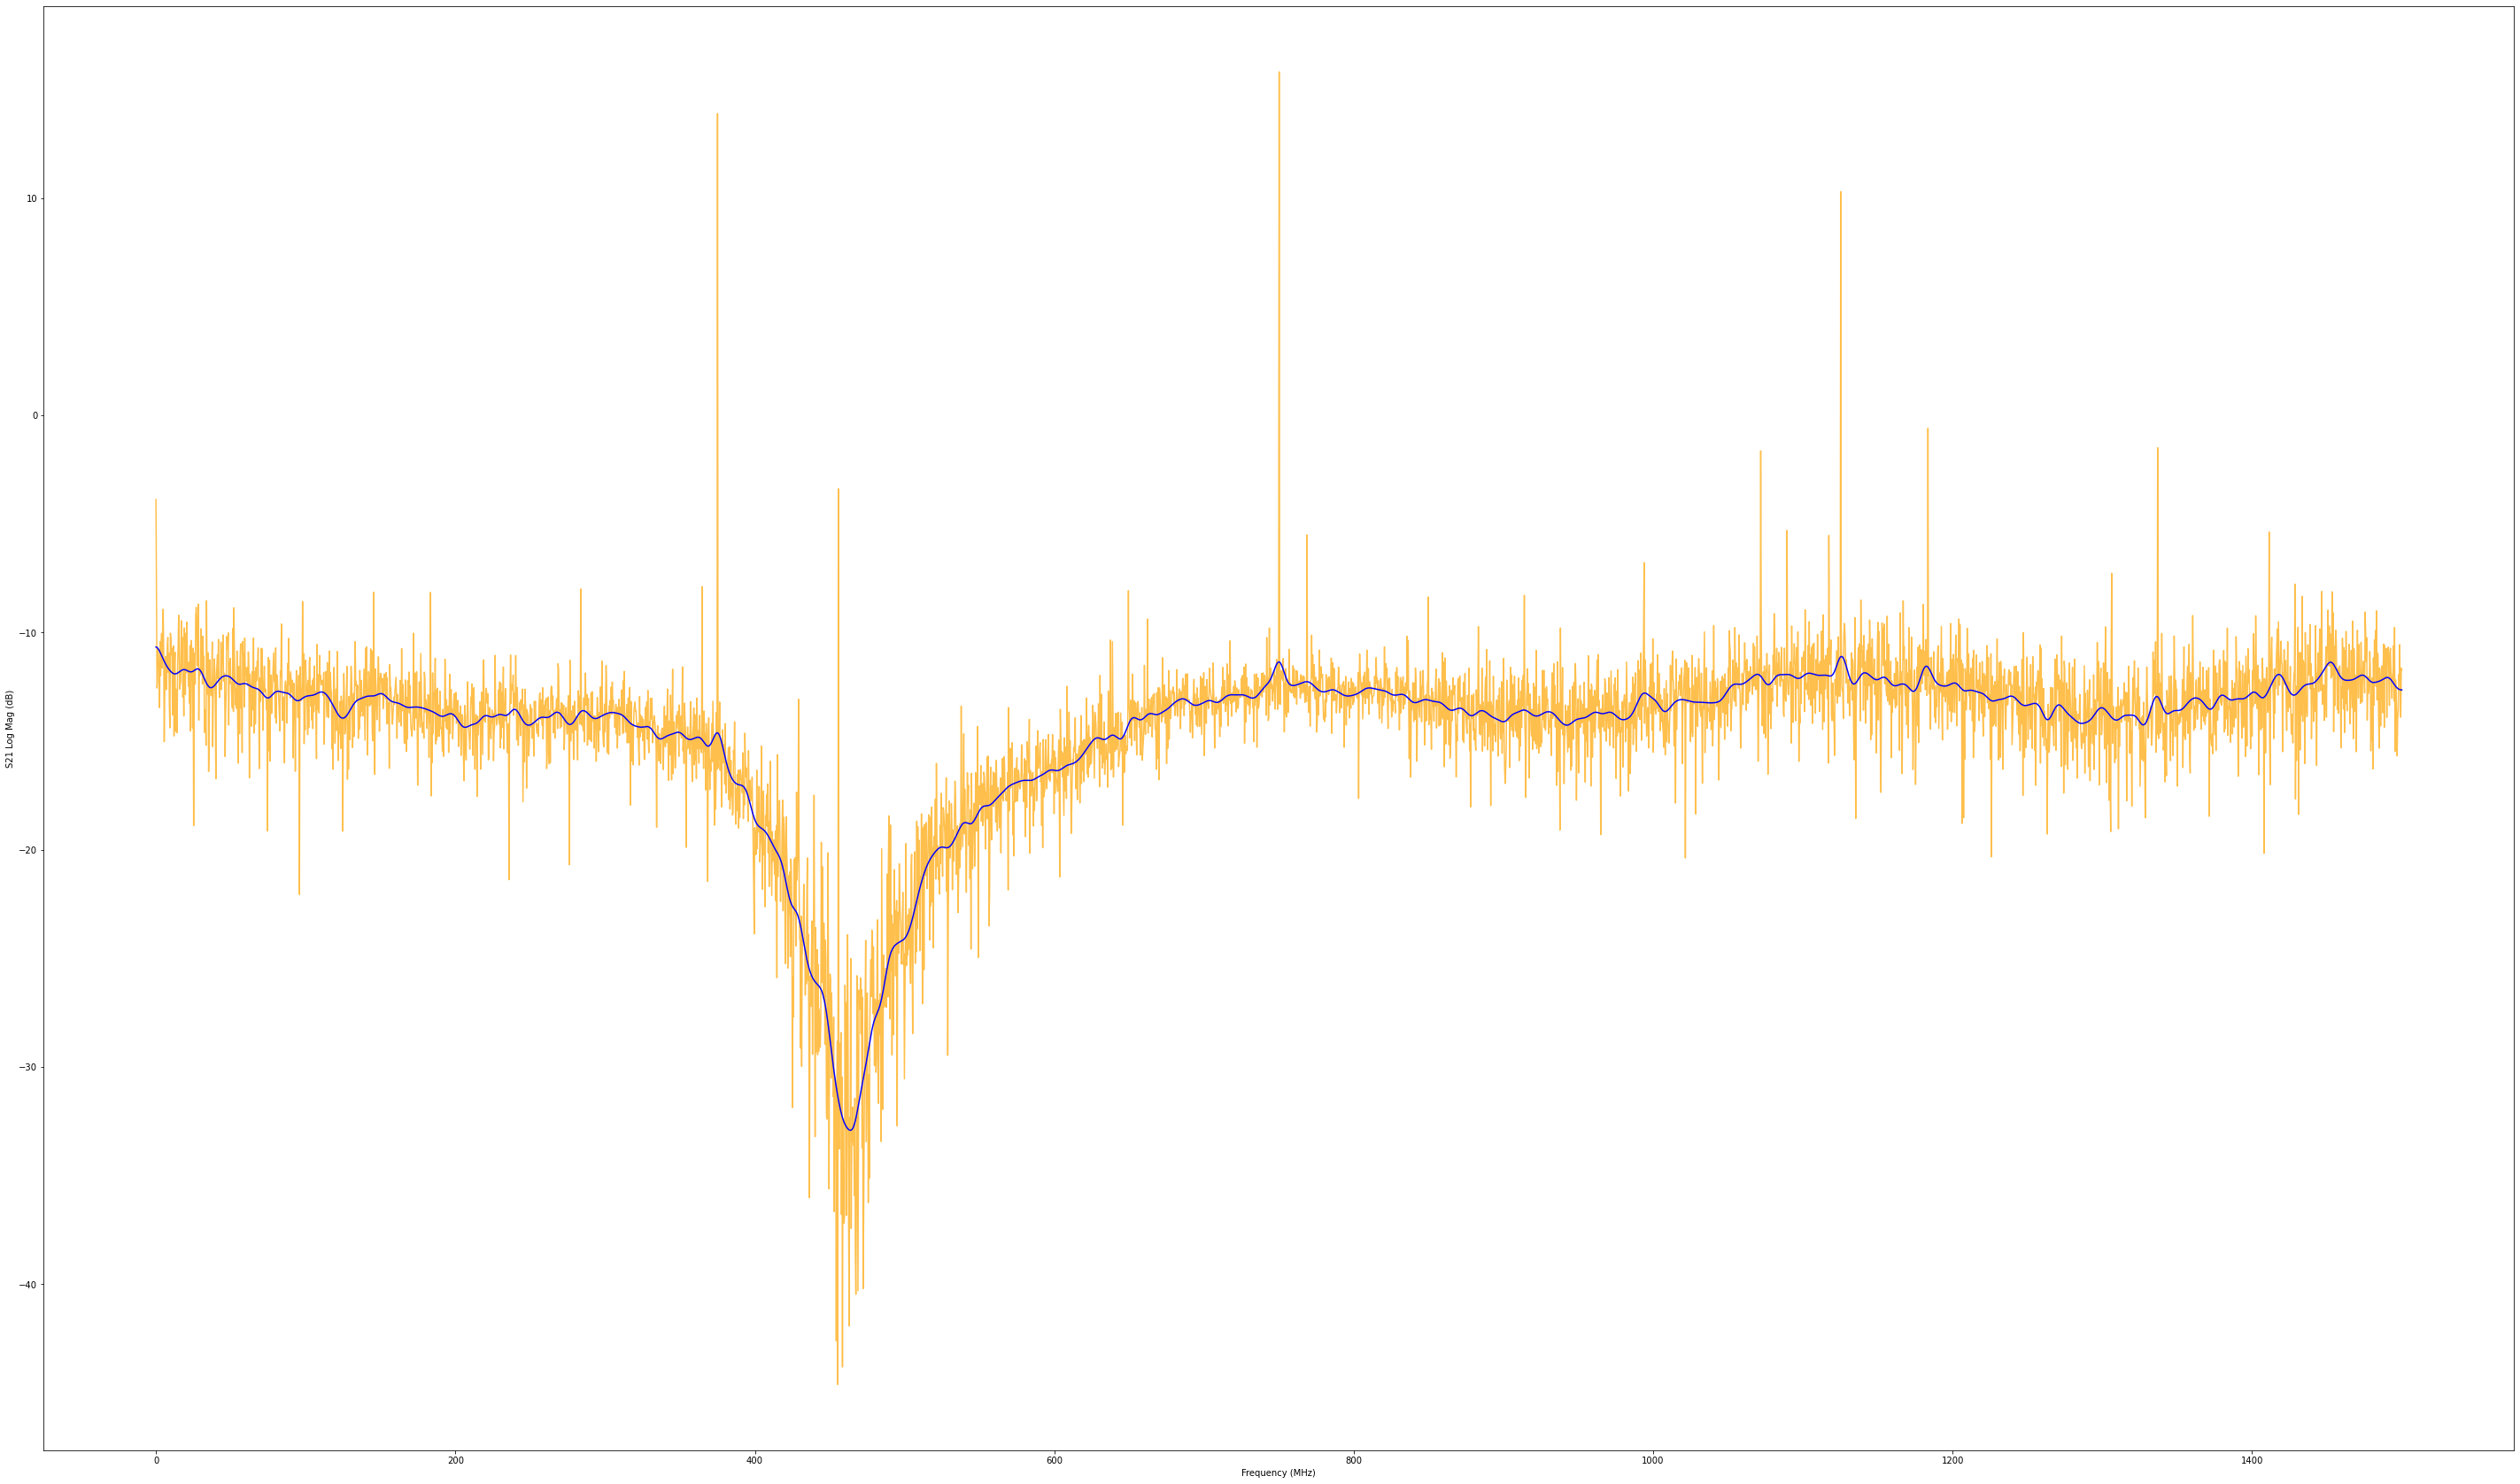

In [25]:
fig, axS21 = plt.subplots(1, 1, figsize=(50, 30))

xf, S21_log_mag= capture_loop(1000,17)

axS21.plot(xf/10**6, S21_log_mag, label='Raw Specturm', color='orange', alpha=0.7)
axS21.set_xlabel("Frequency (MHz)")
axS21.set_ylabel("S21 Log Mag (dB)")

sigma = 10
y_smoothed_gauss = gaussian_filter1d(S21_log_mag, sigma=sigma)
axS21.plot(xf/10**6, y_smoothed_gauss, label='Smoothed (Gaussian)', color='blue')

# axGD.plot(xf/10**6, group_delay_mean, color='orange', alpha=0.7)
# axGD.set_xlabel("Frequency (MHz)")
# axGD.set_ylabel("Group Delay (nanoseconds)")

# sigma = 10
# y_smoothed_gauss = gaussian_filter1d(group_delay_mean, sigma=sigma)
# axGD.plot(xf/10**6, y_smoothed_gauss, label='Smoothed (Gaussian)', color='blue')

print(y_smoothed_gauss[0])
print(np.mean(y_smoothed_gauss[-20:-1]))
print(f'Filter Frequency : {xf[np.argmin(y_smoothed_gauss)]/10**6:3f}MHz | Magnitude {min(y_smoothed_gauss)}')

plt.show()

In [7]:
460
0.01
-1.753966137808965
7.040289604512992

0.2
-2.0361626305350913
7.265702826213245

0.8
-5.004949956996613
9.39203735543091

9.39203735543091

In [8]:
750

0.2
4.9206456230905555
2.7104247837904234

0.8
2.4026426831626626
4.533651013976769

4.533651013976769